In [4]:
'''
Dandan Wei
Jan 19, 2022

This script:
        (i)  filter out the bad pixels for the cropped Landsat EVI and QA_pixel;
        (ii) save the raster data into a time series of EVI with time, coordinates, and QA codes
Input dataset:
        Cropped Landsat7/8 SR_EVI tiff
        Cropped Landsat7/8 QA_Pixel tiff
Output dataset:
        A dataframe of daily EVI with best pixels

'''

import gdal, ogr, osr
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import math
import pandas as pd
from datetime import datetime
import glob


################################################################
#                                                              #
#       Quality control based on QA_pixel band                 #
#                                                              #
################################################################
# LS08 Collection 1 codes : 322,   386,   834,   898,   1346(NA)
# LS08 Collection 2 codes : 21824, 22080, 54596, 54852, none
# 21824 - 0101010101000000
# 22080 - 0101011001000000
# 54596 - 1101010101000100
# 54852 - 1101011001000100
lsat_8_codes = [21824, 22080, 54596, 54852]
# LS08 Collection 1 codes : 66,   130
# LS08 Collection 2 codes : 5440, 5696, 54596, 54852, none
# 5440 - 01010101000000
# 5696 - 01011001000000
lsat_7_codes = [5440, 5696]

################################################################
#                                                              #
#               Define directories and filenames               #
#                                                              #
################################################################
DataDir     = "/data0/dwei/Landsat/2021/TimeSeries/" 
CropDir     = "/data0/dwei/Landsat/2021/cropped_to_NYC/" 
FigDir_temp = "/data0/dwei/temp/"
ShpeDir     = "/data0/dwei/NYCshapefiles/"
NYCshapefile= 'geo_export_a8b5d138-820a-4931-8d11-fe8604ea5bd1.shp'

def get_geotransform(raster_file_path, show_flag):
    ''' 
    To print the GeoTransform of a raster file
    '''
    ds = gdal.Open(raster_file_path)
    gt = ds.GetGeoTransform()
    if show_flag:
        print(gt)
    return gt 

All_files = glob.glob(CropDir+'*SR*')
LC8_files = glob.glob(CropDir+'*LC08*SR_EVI*')
LC7_files = glob.glob(CropDir+'*LE07*SR_EVI*')
# print(np.size(LC8_files))
# print(np.size(LC7_files))
# print(np.size(All_files))

# Check the geotransforms of all cropped files (both LS7 and LS8)
# to make sure they have the same coordinates 
gtall=[]
for file in All_files:
    gt = list(get_geotransform(file, False))
    gtall.append(gt)

iii = gtall[0]
for gt in gtall:
    if iii != gt:
        break
        print("The geotransform is not consistent!!!!")
print("The geotransform is consistent! Go ahead!")

test  = LC8_files[0]
gt_evi= get_geotransform(test, False)
x_ul  = gt_evi[0]
y_ul  = gt_evi[3]
x_res = gt_evi[1]        # W-E resolution
y_res = gt_evi[5]        # N-S resolution
n_row = np.shape(rasterio.open(test).read(1))[0]
n_col = np.shape(rasterio.open(test).read(1))[1]
# print(x_ul, y_ul, x_res, y_res, n_row, n_col)
xtst  = np.arange(x_ul, x_ul+x_res*n_col, x_res)
ytst  = np.arange(y_ul, y_ul+y_res*n_row, y_res)
X, Y  = np.meshgrid(xtst, ytst)
# Convert to 1D
X_1D   = X.reshape([np.size(X)])
Y_1D   = Y.reshape([np.size(Y)])  
# print(np.shape(X))
# print(np.shape(Y))


The geotransform is consistent! Go ahead!


In [16]:
# The pixel quality control for Landsat 7
start_time = time.time()
print("=========== Quality control for Landsat 7 =============")

for evi_file in LC7_files:
    
    # find the corresponding B4, B5, and QA_PIXEL files
    strr    = evi_file[0:84]
    qa_file = glob.glob(strr+'*QA_PIXEL*')[0]
    B4_file = glob.glob(strr+'*SR_B4*')[0]
    B5_file = glob.glob(strr+'*SR_B5*')[0]
    
    # Check if the files match
    time_evi = evi_file[61:69]
    time_qa  = qa_file[61:69]
    time_b4  = B4_file[61:69]
    time_b5  = B5_file[61:69]
    if time_evi!=time_qa or time_evi!=time_b4 or time_evi!=time_b5:
        break
        print("The EVI file doesn't not match the QA file! Check!")
        
    # Timestamp
    dt = datetime.strptime(time_evi, '%Y%m%d')
    dd = dt.date()  # only date without time
    print("The date is", dd)
        
    # Convert the EVI and QA into 1D arrays
    qa_rast  = rasterio.open(qa_file)
    evi_rast = rasterio.open(evi_file)
    b4_rast  = rasterio.open(B4_file)
    b5_rast  = rasterio.open(B5_file)
    qa       = qa_rast.read(1)
    evi      = evi_rast.read(1)*0.0001
    b4       = b4_rast.read(1)*0.0001
    b5       = b5_rast.read(1)*0.0001
    qa_1D    = qa.reshape(np.size(qa))
    evi_1D   = evi.reshape(np.size(qa))
    b4_1D    = b4.reshape(np.size(qa))
    b5_1D    = b5.reshape(np.size(qa))
    lswi_1D  = np.divide(np.subtract(b4_1D,b5_1D), np.add(b4_1D,b5_1D)) 
    # print('EVI datatype :', type(evi_1D))
  
    # Find and filter the bad pixels
    bad_pixel         = [pixel not in lsat_7_codes for pixel in qa_1D]
    n_bad_pixel       = [n for n in bad_pixel if n==True] 
    evi_1D[bad_pixel] = np.nan
    lswi_1D[bad_pixel]= np.nan
    percent_bad       = np.size(n_bad_pixel)/np.size(bad_pixel)*100
    print('The bad pixel percent is :', percent_bad)
    
#     # Plot the pre- and post-QA EVI
#     [fig, ax] = plt.subplots(1, 2)
#     fig.suptitle("Bad pixel percent is "+str(percent_bad)+'%.', fontsize=16)
#     ax[0].imshow(lswi_1D.reshape(np.shape(evi)))
#     ax[1].imshow(evi_1D.reshape(np.shape(evi)))
#     plt.show()
#     plt.savefig(FigDir_temp + time_evi + 'EVI_LSWI_postQA.png')   
    
    # To create a dataframe with time, coordinates (X, Y), and EVI   
    Data   = pd.DataFrame({"Time":dd, "X":X_1D,'Y':Y_1D,\
                           "EVI":evi_1D,"LSWI":lswi_1D, "QA":qa_1D})
    Data.to_csv(DataDir+'LE7_'+'EVI_LSWI_'+time_evi)
#     print(Data.head())

print("================ Finished in %s minutes ============" \
      %(time.time()/60-start_time/60.))

=========== Quality control for Landsat 7 =============
The date is 2021-12-17


/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


The bad pixel percent is : 99.99958536504462
The date is 2021-10-30
The bad pixel percent is : 100.0
The date is 2021-01-15
The bad pixel percent is : 100.0
The date is 2021-08-11
The bad pixel percent is : 50.12758317577205
The date is 2021-04-21
The bad pixel percent is : 95.48503997080971
The date is 2021-10-14
The bad pixel percent is : 82.79546886920754
The date is 2021-05-07
The bad pixel percent is : 60.685889143198324
The date is 2021-07-26
The bad pixel percent is : 94.50426244734136
The date is 2021-06-08
The bad pixel percent is : 99.4442647692971
The date is 2021-05-23
The bad pixel percent is : 72.51919759843433
The date is 2021-09-12
The bad pixel percent is : 50.32295916674959
The date is 2021-06-24
The bad pixel percent is : 57.15850665074469
The date is 2021-12-01
The bad pixel percent is : 99.65705542840084
The date is 2021-04-05
The bad pixel percent is : 51.8561133777822
The date is 2021-11-15
The bad pixel percent is : 99.33206455036986
The date is 2021-07-10
The b




=========== Quality control for Landsat 8 =============
The date is 2021-10-06
The bad pixel percent is : 100.0


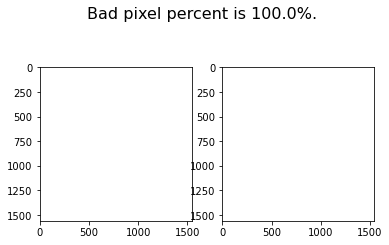

The date is 2021-03-12
The bad pixel percent is : 64.78459714067735


<Figure size 432x288 with 0 Axes>

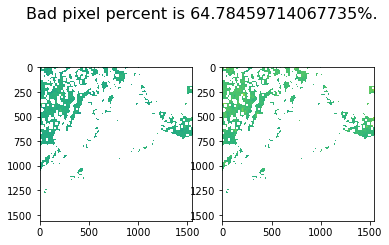

The date is 2021-01-07
The bad pixel percent is : 49.5894284671775


<Figure size 432x288 with 0 Axes>

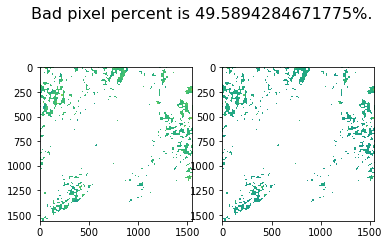

The date is 2021-10-22
The bad pixel percent is : 37.1985603874349


<Figure size 432x288 with 0 Axes>

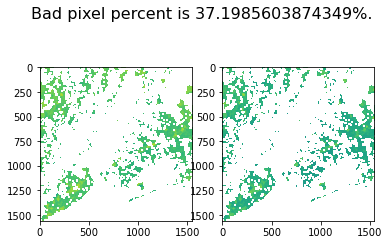

The date is 2021-12-09
The bad pixel percent is : 100.0


<Figure size 432x288 with 0 Axes>

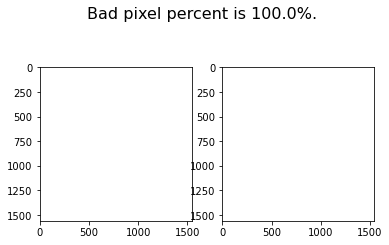

The date is 2021-01-23
The bad pixel percent is : 58.844453842836764


<Figure size 432x288 with 0 Axes>

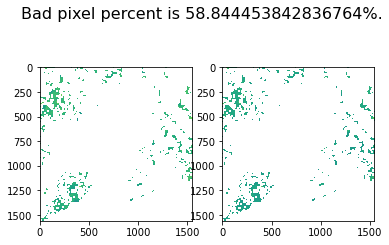

The date is 2021-09-04
The bad pixel percent is : 76.88551099611902


<Figure size 432x288 with 0 Axes>

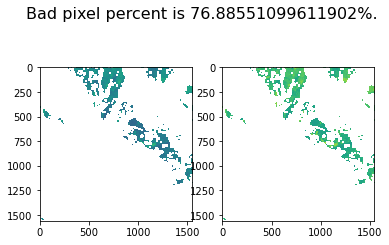

The date is 2021-06-16
The bad pixel percent is : 30.586293826914783


<Figure size 432x288 with 0 Axes>

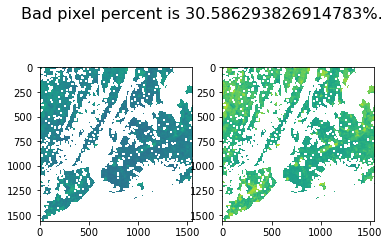

The date is 2021-02-08
The bad pixel percent is : 99.7634507579527


<Figure size 432x288 with 0 Axes>

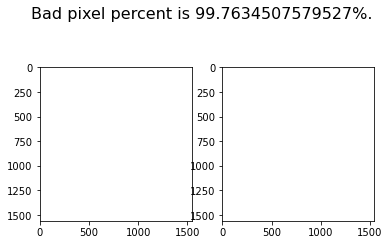

The date is 2021-11-23
The bad pixel percent is : 47.81562012803928


<Figure size 432x288 with 0 Axes>

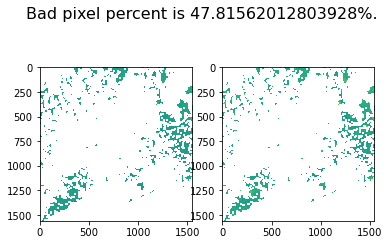

The date is 2021-05-15
The bad pixel percent is : 31.521751749759513


<Figure size 432x288 with 0 Axes>

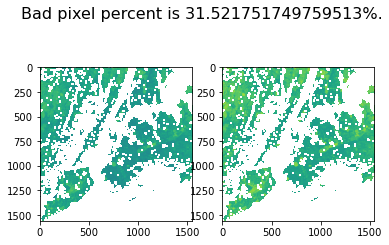

The date is 2021-04-13
The bad pixel percent is : 83.85137824659171


<Figure size 432x288 with 0 Axes>

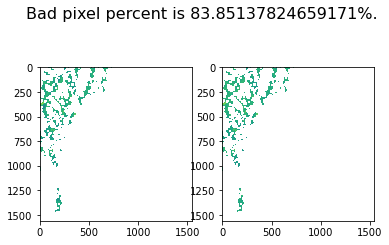

The date is 2021-07-18
The bad pixel percent is : 82.33497528775666


<Figure size 432x288 with 0 Axes>

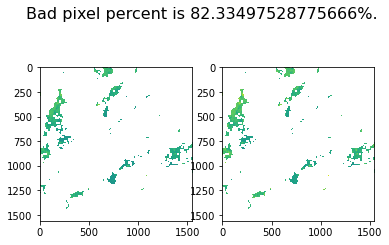

The date is 2021-09-20
The bad pixel percent is : 63.71106577768933


<Figure size 432x288 with 0 Axes>

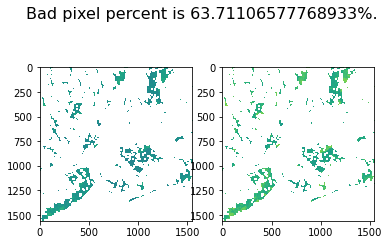

The date is 2021-08-19
The bad pixel percent is : 98.57564600126048


<Figure size 432x288 with 0 Axes>

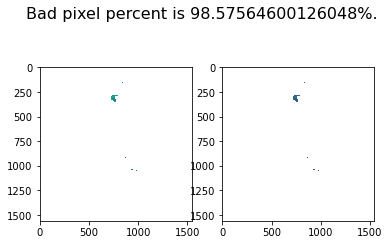

The date is 2021-02-24
The bad pixel percent is : 99.78248250240487


<Figure size 432x288 with 0 Axes>

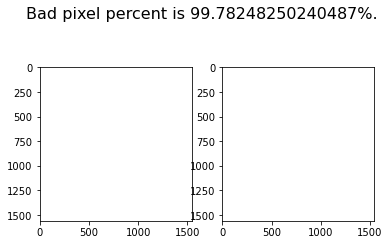

The date is 2021-11-07
The bad pixel percent is : 42.41711447241848


<Figure size 432x288 with 0 Axes>

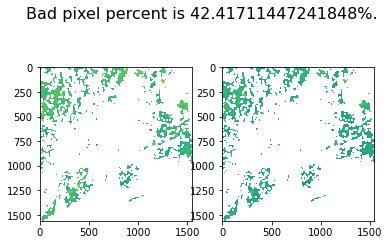

================ Finished in 5.625120211392641 minutes ============


<Figure size 432x288 with 0 Axes>

In [18]:
# Landsat 8 quality control
start_time = time.time()
print("\n\n")
print("=========== Quality control for Landsat 8 =============")

for evi_file in LC8_files:
    
    # find the corresponding QA file
    strr = evi_file[0:84]
    qa_file = glob.glob(strr+'*QA_PIXEL*')[0]
    B6_file = glob.glob(strr+'*SR_B6*')[0]
    B5_file = glob.glob(strr+'*SR_B5*')[0]
    
    # Check if the files match
    time_evi = evi_file[61:69]
    time_qa  = qa_file[61:69]
    time_b6  = B6_file[61:69]
    time_b5  = B5_file[61:69]
    if time_evi!=time_qa or time_evi!=time_b6 or time_evi!=time_b5:
        break
        print("The EVI file doesn't not match the QA file!")
        
    # Convert time string to python datetime format
    dt = datetime.strptime(time_evi, '%Y%m%d')
    dd = dt.date()  # only date without time
    print("The date is", dd)
        
    # Convert the EVI and QA into 1D arrays
    qa_rast  = rasterio.open(qa_file)
    evi_rast = rasterio.open(evi_file)
    b6_rast  = rasterio.open(B6_file)
    b5_rast  = rasterio.open(B5_file)
    qa       = qa_rast.read(1)
    evi      = evi_rast.read(1)*0.0001   
    b6       = b6_rast.read(1)*0.0001
    b5       = b5_rast.read(1)*0.0001
    qa_1D    = qa.reshape(np.size(qa))
    evi_1D   = evi.reshape(np.size(qa))
    b6_1D    = b6.reshape(np.size(qa))
    b5_1D    = b5.reshape(np.size(qa))
    lswi_1D  = np.divide(np.subtract(b5_1D,b6_1D), np.add(b5_1D,b6_1D)) 
    # print('EVI datatype :', type(evi_1D))
  
    # Find and filter the bad pixels
    bad_pixel         = [pixel not in lsat_8_codes for pixel in qa_1D]
    n_bad_pixel       = [n for n in bad_pixel if n==True] 
    evi_1D[bad_pixel] = np.nan 
    lswi_1D[bad_pixel]= np.nan
    percent_bad       = np.size(n_bad_pixel)/np.size(bad_pixel)*100
    print('The bad pixel percent is ', percent_bad)
    
    # Plot the pre- and post-QA EVI
    [fig, ax] = plt.subplots(1, 2)
    fig.suptitle("Bad pixel percent is "+str(percent_bad)+'%.', fontsize=16)
    ax[0].imshow(lswi_1D.reshape(np.shape(evi)))
    ax[1].imshow(evi_1D.reshape(np.shape(evi)))
    plt.show()
    plt.savefig(FigDir_temp + time_evi + 'EVI_LSWI_postQA.png')   

    # To create a dataframe with time, coordinates (X, Y), and EVI   
    Data   = pd.DataFrame({"Time":dd, "X":X_1D,'Y':Y_1D,\
                           "EVI":evi_1D,"LSWI":lswi_1D, "QA":qa_1D})
    # print(Data.head())
    Data.to_csv(DataDir+'LC8_'+'EVI_LSWI_'+time_evi)
    
print("================ Finished in %s minutes ============" \
      %(time.time()/60-start_time/60.))

